In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, math
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
import pickle
BASE_PATH = "/kaggle/input/cifar-10-and-cifar-10-c/cifar-10-python/cifar-10-batches-py"

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict

In [22]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(test_batch[b'data'])
test_label.extend(test_batch[b'labels'])

y_test = np.array(test_label)    

In [23]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

# Converting a Fla

In [24]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

test_data_flat = np.vstack(test_data)   
test_images = cifar_dataset_to_pil(test_data_flat)

In [25]:
import torch

model_path = "/kaggle/input/wec-task-3/pytorch/default/1/best_model.pth"
state_dict = torch.load(model_path, map_location='cpu')

for k, v in state_dict.items():
    print(k, v.shape)


conv1.weight torch.Size([64, 3, 3, 3])
conv1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
conv6.weight torch.Size([256, 256, 3, 3])
conv6.bias torch.Size([256])
conv7.weight torch.Size([512, 256, 3, 3])
conv7.bias torch.Size([512])
conv8.weight torch.Size([512, 512, 3, 3])
conv8.bias torch.Size([512])
conv9.weight torch.Size([512, 512, 3, 3])
conv9.bias torch.Size([512])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
bn2.weight torch.Size([256])
bn2.bias torch.Size([256])
bn2.running_mean torch.Size([256])
bn2.running_var torch.Size([256])
bn2.num_batches_tracked torch.Size([])
bn3.weight torch.Size([512])
bn3.bias torc

In [26]:
class AdvancedCNNCheckpoint(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, 3, padding=1)

        # BatchNorm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)

        # Pooling + dropout
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout2d(0.2)

        # Fully connected layers (matches checkpoint exactly)
        self.fc1 = nn.Linear(512*4*4, 8192)
        self.fc2 = nn.Linear(8192, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = AdvancedCNNCheckpoint(num_classes=10)

state_dict = torch.load(model_path, map_location=device)
net.load_state_dict(state_dict)
net.to(device)
net.eval()

AdvancedCNNCheckpoint(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [28]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

In [29]:
import numpy as np
import cv2

# ----------------------
# Gaussian Noise
# ----------------------
def add_gaussian_noise_np(img, sigma):
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# ----------------------
# Poisson / ISO Noise
# ----------------------
def add_poisson_noise_np(img, scale=1.0):
    img_scaled = img * scale
    noisy_img = np.random.poisson(img_scaled).astype(np.float32) / scale
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# ----------------------
# Gaussian Blur
# ----------------------
def gaussian_blur_np(img, sigma):
    ksize = max(1, int(6*sigma+1) | 1)
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma)
    return blurred

# ----------------------
# Motion Blur
# ----------------------
def motion_blur_np(img, length=5, angle=0):
    kernel = np.zeros((length, length))
    kernel[int((length-1)/2), :] = np.ones(length)
    M = cv2.getRotationMatrix2D((length/2-0.5, length/2-0.5), angle*180/np.pi, 1)
    kernel = cv2.warpAffine(kernel, M, (length, length))
    kernel = kernel / kernel.sum() if kernel.sum()!=0 else kernel
    blurred = cv2.filter2D(img, -1, kernel)
    return blurred

# ----------------------
# JPEG Compression
# ----------------------
def jpeg_compression_np(img, quality=50):
    # Convert RGB→BGR for OpenCV
    _, encimg = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    decimg = cv2.imdecode(encimg, 1)
    # Convert back to RGB
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    return decimg

# ----------------------
# Brightness / Contrast
# ----------------------
def adjust_brightness_contrast_np(img, brightness=1.0, contrast=1.0):
    img = img.astype(np.float32)
    img = img * contrast + (brightness-1)*128
    return np.clip(img, 0, 255).astype(np.uint8)

# ----------------------
# Color Shift (Hue/Saturation)
# ----------------------
def color_shift_np(img, hue_shift_deg=0, sat_shift=0.0):
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,0] = (hsv[...,0] + hue_shift_deg) % 180
    hsv[...,1] = np.clip(hsv[...,1] + sat_shift*255, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

In [45]:
corruption_appliers = {
    "gaussian_noise": lambda im, lvl: add_gaussian_noise_np(im, sigma=lvl),
    "poisson_noise": lambda im, lvl: add_poisson_noise_np(im, scale=lvl),
    "gaussian_blur": lambda im, lvl: gaussian_blur_np(im, sigma=lvl),
    "motion_blur": lambda im, lvl: motion_blur_np(im, length=int(lvl), angle=random.uniform(0, 2*math.pi)),
    "jpeg_compression": lambda im, lvl: cv2.cvtColor(jpeg_compression_np(cv2.cvtColor(im, cv2.COLOR_RGB2BGR), quality=int(lvl)), cv2.COLOR_BGR2RGB),
    "brightness": lambda im, lvl: adjust_brightness_contrast_np(im, brightness=float(lvl), contrast=1.0),
    "contrast": lambda im, lvl: adjust_brightness_contrast_np(im, brightness=1.0, contrast=float(lvl)),
    "color_shift": lambda im, lvl: color_shift_np(im, hue_shift_deg=int(lvl[0]), sat_shift=float(lvl[1]))
}

corruption_params = {
    "gaussian_noise": [0, 2, 5, 10, 15, 20, 30, 40, 60, 80],
    "poisson_noise": [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4],
    "gaussian_blur": [0, 0.5, 1, 1.5, 2, 3, 4, 6, 8],
    "motion_blur": [1, 2, 3, 5, 7, 10, 15, 20, 25],
    "jpeg_compression": [100, 95, 90, 85, 80, 70, 60, 50, 40, 30, 20, 10],
    "brightness": [0.3, 0.5, 0.65, 0.75, 1, 1.15, 1.25, 1.4, 1.5, 1.7],
    "contrast": [0.3, 0.5, 0.65, 0.75, 1, 1.15, 1.25, 1.4, 1.5, 1.7],
    "color_shift": [(0,0), (5,0.05), (10,0.1), (15,0.15), (20,0.2), (25,0.25), (30,0.3), (40,0.4)]
}


In [46]:
def evaluate_model_on_corruption(model, images_pil, labels, corruption_name, levels, batch_size=128):
    model.eval()
    results = []
    applier = corruption_appliers[corruption_name]

    for lvl in levels:
        correct, total = 0, 0
        for bstart in range(0, len(images_pil), batch_size):
            batch_imgs = images_pil[bstart:bstart+batch_size]
            batch_labels = labels[bstart:bstart+batch_size]
            batch_tensor = []

            for img in batch_imgs:
                np_img = np.array(img)
                corrupted_np = applier(np_img, lvl)
                corrupted_pil = Image.fromarray(corrupted_np)
                batch_tensor.append(preprocess(corrupted_pil))

            batch_tensor = torch.stack(batch_tensor).to(device)
            batch_labels_tensor = torch.tensor(batch_labels, device=device)

            with torch.no_grad():
                outputs = model(batch_tensor)
                preds = outputs.argmax(dim=1)
                correct += (preds == batch_labels_tensor).sum().item()
                total += batch_labels_tensor.size(0)

        acc = correct / total
        print(f"{corruption_name} level {lvl} -> accuracy {acc:.4f}")
        results.append(acc)
    return results


In [47]:
robustness_results = {}
for corr in corruption_params:
    print(f"Evaluating: {corr}")
    levels = corruption_params[corr]
    accs = evaluate_model_on_corruption(net, test_images, y_test, corr, levels)
    robustness_results[corr] = (levels, accs)

Evaluating: gaussian_noise
gaussian_noise level 0 -> accuracy 0.9104
gaussian_noise level 2 -> accuracy 0.9111
gaussian_noise level 5 -> accuracy 0.8943
gaussian_noise level 10 -> accuracy 0.8026
gaussian_noise level 15 -> accuracy 0.6666
gaussian_noise level 20 -> accuracy 0.5356
gaussian_noise level 30 -> accuracy 0.3343
gaussian_noise level 40 -> accuracy 0.2178
gaussian_noise level 60 -> accuracy 0.1238
gaussian_noise level 80 -> accuracy 0.1086
Evaluating: poisson_noise
poisson_noise level 0.1 -> accuracy 0.3081
poisson_noise level 0.25 -> accuracy 0.5165
poisson_noise level 0.5 -> accuracy 0.6566
poisson_noise level 0.75 -> accuracy 0.7264
poisson_noise level 1 -> accuracy 0.7763
poisson_noise level 1.5 -> accuracy 0.8208
poisson_noise level 2 -> accuracy 0.4739
poisson_noise level 3 -> accuracy 0.3561
poisson_noise level 4 -> accuracy 0.2650
Evaluating: gaussian_blur
gaussian_blur level 0 -> accuracy 0.9104
gaussian_blur level 0.5 -> accuracy 0.9046
gaussian_blur level 1 -> accu

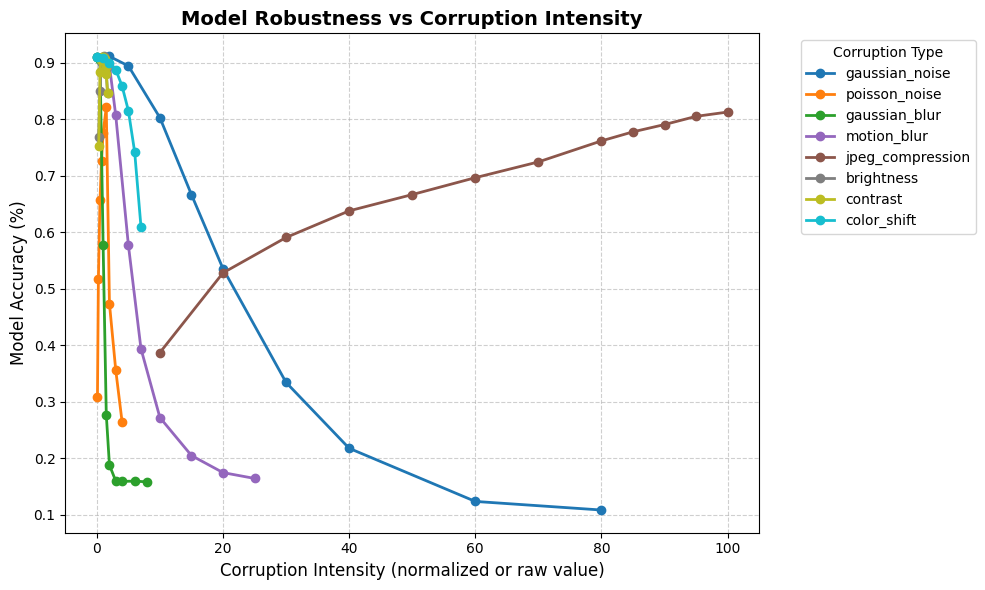

In [48]:
plt.figure(figsize=(10,6))

colors = plt.cm.tab10(np.linspace(0, 1, len(robustness_results)))

for (corr, (lvls, accs)), color in zip(robustness_results.items(), colors):
    x = list(range(len(lvls))) if isinstance(lvls[0], tuple) else lvls
    plt.plot(x, accs, marker='o', label=corr, color=color, linewidth=2, markersize=6)

plt.title("Model Robustness vs Corruption Intensity", fontsize=14, fontweight='bold')
plt.xlabel("Corruption Intensity (normalized or raw value)", fontsize=12)
plt.ylabel("Model Accuracy (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Corruption Type")
plt.tight_layout()  # Prevents label/legend cutoff
plt.show()

The plotted results show that the model’s accuracy drops sharply under Gaussian and Poisson noise, indicating a high sensitivity to random pixel disturbances. Gaussian and motion blur also lead to noticeable degradation, suggesting that the model relies heavily on sharp edges and spatial detail for its predictions. In contrast, changes in brightness, contrast, and color shift have only a minor effect, showing that the model can handle moderate illumination and color variations

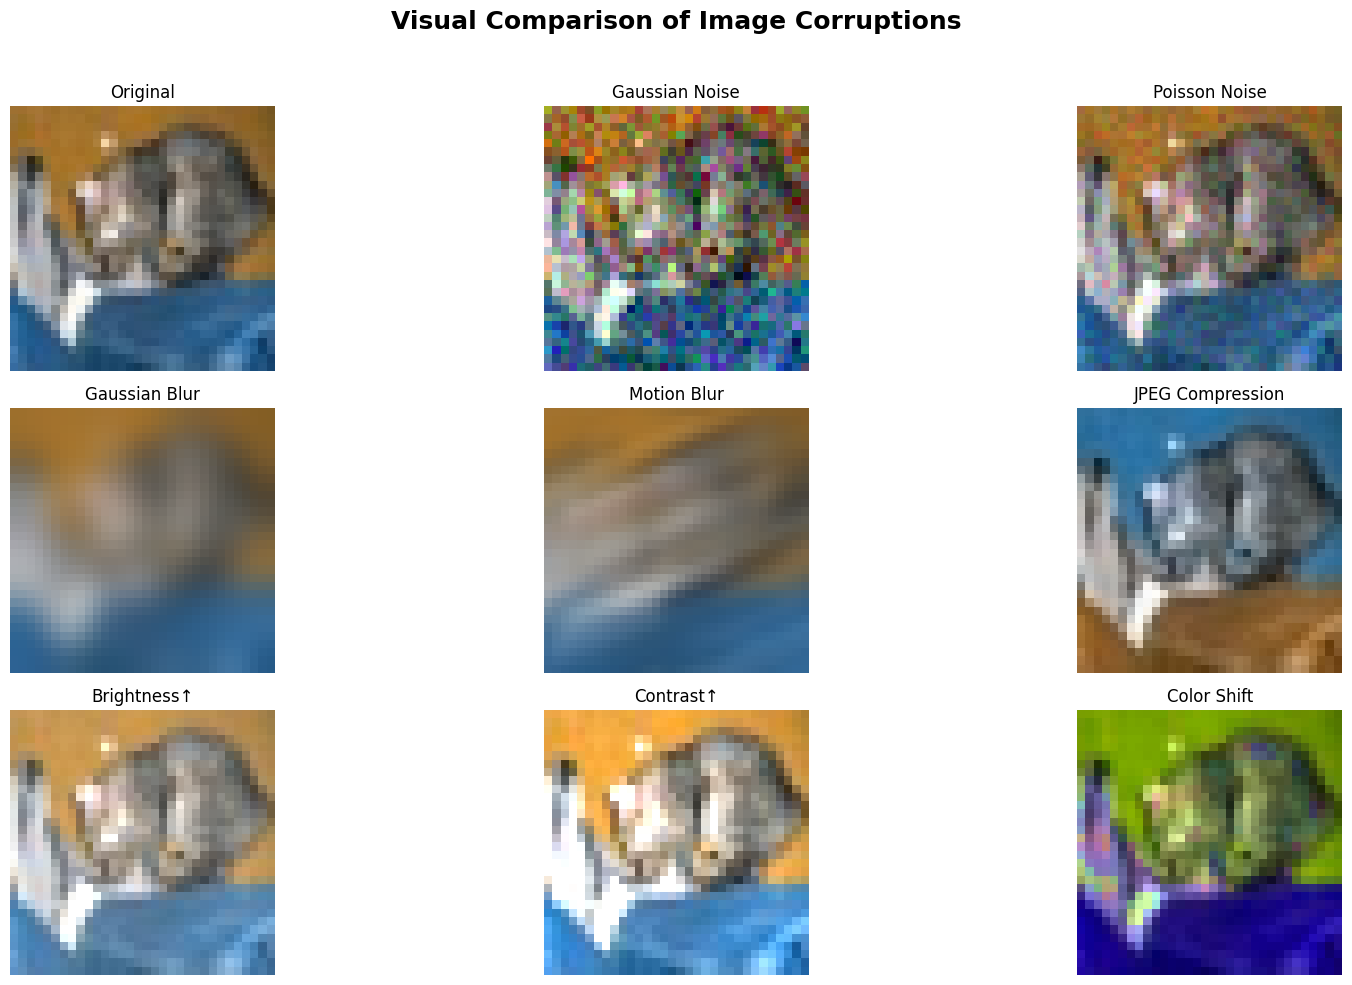

In [49]:
img = test_images[0]

img = np.array(img)

if img.dtype != np.uint8:
    img = (img * 255).astype(np.uint8)

corruptions = {
    "Original": img,
    "Gaussian Noise": add_gaussian_noise_np(img, sigma=25),
    "Poisson Noise": add_poisson_noise_np(img, scale=1.0),
    "Gaussian Blur": gaussian_blur_np(img, sigma=2),
    "Motion Blur": motion_blur_np(img, length=15, angle=np.pi/8),
    "JPEG Compression": jpeg_compression_np(img, quality=100),
    "Brightness↑": adjust_brightness_contrast_np(img, brightness=1.3, contrast=1.0),
    "Contrast↑": adjust_brightness_contrast_np(img, brightness=1.0, contrast=1.5),
    "Color Shift": color_shift_np(img, hue_shift_deg=20, sat_shift=0.3),
}

plt.figure(figsize=(18, 10))

for i, (name, corrupted) in enumerate(corruptions.items(), 1):
    plt.subplot(3, 3, i)
    plt.imshow(corrupted)
    plt.title(name, fontsize=12)
    plt.axis('off')

plt.suptitle("Visual Comparison of Image Corruptions", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
